In [2]:
from torch_geometric.datasets import NELL
from torch_geometric.datasets import KarateClub
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import torch

dataset = KarateClub()

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
# data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class GAT(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super(GAT,self).__init__()    # 构造函数

        self.conv1 = GCNConv(in_channels=in_c, out_channels=hid_c)
        self.conv2 = GCNConv(in_channels=hid_c, out_channels=out_c)
  
    def forward(self, data):
        x, edge_index = data.x, data.edge_index    # x:节点特征矩阵; edge_index:COO格式的图形连接，维度[2,边的数量]，数据：[ [源节点],[目标节点] ]
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        
        x1 = F.log_softmax(x, dim=1)
        
        return x1, x

model = GAT(in_c=dataset.num_node_features,hid_c=100,out_c=dataset.num_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

print(model(data))

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out1, out = model(data)
    # 交叉熵损失
    loss = F.nll_loss(out1[data.train_mask], data.y[data.train_mask])       # 负对数似然。
    loss.backward()
    optimizer.step()
    print('epoch:',epoch, 'loss:',loss.item())  

print(out)

(tensor([[-3.5951, -3.5336, -3.6310,  ..., -3.4709, -3.5619, -3.5976],
        [-3.5482, -3.5157, -3.5829,  ..., -3.5039, -3.5670, -3.5508],
        [-3.5545, -3.5155, -3.6052,  ..., -3.5279, -3.5720, -3.5684],
        ...,
        [-3.5640, -3.5059, -3.5695,  ..., -3.5108, -3.5491, -3.5659],
        [-3.5708, -3.5797, -3.6752,  ..., -3.5233, -3.5095, -3.5829],
        [-3.5853, -3.5799, -3.6937,  ..., -3.5201, -3.5231, -3.6080]],
       grad_fn=<LogSoftmaxBackward>), tensor([[-0.0831, -0.0216, -0.1190,  ...,  0.0410, -0.0499, -0.0856],
        [-0.0303,  0.0022, -0.0650,  ...,  0.0140, -0.0491, -0.0329],
        [-0.0352,  0.0038, -0.0858,  ..., -0.0086, -0.0526, -0.0491],
        ...,
        [-0.0439,  0.0143, -0.0493,  ...,  0.0094, -0.0289, -0.0457],
        [-0.0472, -0.0561, -0.1516,  ...,  0.0004,  0.0141, -0.0593],
        [-0.0606, -0.0553, -0.1691,  ...,  0.0046,  0.0015, -0.0834]],
       grad_fn=<AddBackward0>))
epoch: 0 loss: 3.520704507827759
epoch: 1 loss: 3.50671601295

epoch: 236 loss: 0.17195086181163788
epoch: 237 loss: 0.16995379328727722
epoch: 238 loss: 0.16799308359622955
epoch: 239 loss: 0.1660623848438263
epoch: 240 loss: 0.1641615629196167
epoch: 241 loss: 0.16229046881198883
epoch: 242 loss: 0.16044874489307404
epoch: 243 loss: 0.15863636136054993
epoch: 244 loss: 0.15685142576694489
epoch: 245 loss: 0.15509429574012756
epoch: 246 loss: 0.1533636450767517
epoch: 247 loss: 0.15166190266609192
epoch: 248 loss: 0.14998692274093628
epoch: 249 loss: 0.14833879470825195
epoch: 250 loss: 0.1467139720916748
epoch: 251 loss: 0.1451144963502884
epoch: 252 loss: 0.1435399353504181
epoch: 253 loss: 0.14198920130729675
epoch: 254 loss: 0.14046058058738708
epoch: 255 loss: 0.13895533978939056
epoch: 256 loss: 0.13747245073318481
epoch: 257 loss: 0.13601166009902954
epoch: 258 loss: 0.13457360863685608
epoch: 259 loss: 0.13315577805042267
epoch: 260 loss: 0.13176053762435913
epoch: 261 loss: 0.1303853839635849
epoch: 262 loss: 0.12903156876564026
epoch: 2

epoch: 469 loss: 0.03096626326441765
epoch: 470 loss: 0.030826617032289505
epoch: 471 loss: 0.030688278377056122
epoch: 472 loss: 0.03055058792233467
epoch: 473 loss: 0.030414260923862457
epoch: 474 loss: 0.030279263854026794
epoch: 475 loss: 0.030144743621349335
epoch: 476 loss: 0.030011728405952454
epoch: 477 loss: 0.02987983077764511
epoch: 478 loss: 0.029749643057584763
epoch: 479 loss: 0.029619820415973663
epoch: 480 loss: 0.029490584507584572
epoch: 481 loss: 0.02936314046382904
epoch: 482 loss: 0.029236964881420135
epoch: 483 loss: 0.029111545532941818
epoch: 484 loss: 0.02898668311536312
epoch: 485 loss: 0.02886296808719635
epoch: 486 loss: 0.028740154579281807
epoch: 487 loss: 0.02861853316426277
epoch: 488 loss: 0.028498098254203796
epoch: 489 loss: 0.02837861329317093
epoch: 490 loss: 0.02825971692800522
epoch: 491 loss: 0.028141994029283524
epoch: 492 loss: 0.028025083243846893
epoch: 493 loss: 0.027909521013498306
epoch: 494 loss: 0.027794592082500458
epoch: 495 loss: 0.02

In [4]:
import pandas as pd
from sklearn import cluster
from sklearn import metrics

out=out.cpu().detach().numpy()
model = cluster.KMeans(n_clusters=4)
model.fit(out)

y_predict = model.predict(out)

# Calinski-Harabaz Index：越大越好
# Silhouette Coefficient：轮廓系数（越大越好)
print('Calinski-Harabaz Index：',metrics.calinski_harabasz_score(out,y_predict))
print('Silhouette Coefficient：',metrics.silhouette_score(out,y_predict))

Calinski-Harabaz Index： 38.46212906145406
Silhouette Coefficient： 0.4816


In [5]:
from sklearn.manifold import TSNE
t_sne = TSNE()
data=t_sne.fit_transform(out)
data=pd.DataFrame(data)
data = pd.DataFrame(data,index=y_predict)
data_tsne = pd.DataFrame(t_sne.embedding_, index =y_predict)
data_tsne

,0,1
2,12.631412,74.320702
2,-24.364256,52.330948
2,-3.214460,52.606445
3,-22.385569,16.921469
0,-61.899113,-1.362327
0,-66.611839,23.195040
0,-54.033928,41.592388
1,-19.960463,-0.818222
1,32.524612,39.424358
1,29.584946,2.134078


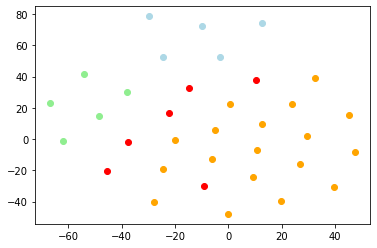

In [6]:
from matplotlib import pyplot as plt
d = data_tsne[data_tsne.index == 0]     #找出聚类类别为0的数据对应的降维结果
plt.scatter(d[0], d[1],c='lightgreen',marker='o')
d = data_tsne[data_tsne.index == 1]
plt.scatter(d[0], d[1], c='orange',	marker='o')
d = data_tsne[data_tsne.index == 2]
plt.scatter(d[0], d[1], c='lightblue',marker='o')
d = data_tsne[data_tsne.index == 3]
plt.scatter(d[0], d[1], c='red',marker='o')